In [ ]:
! pip install -q kaggle

In [ ]:
 from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kashishjalan02","key":"471f4ccf28385a5ad9c9a86ebc8bb096"}'}

In [ ]:
 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download gti-upm/leapgestrecog

100% 2.13G/2.13G [01:57<00:00, 21.4MB/s]
100% 2.13G/2.13G [01:57<00:00, 19.5MB/s]


In [ ]:
! unzip /content/leapgestrecog.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: data/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: data/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: data/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: data/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: data/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: data/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: data/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: data/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: data/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: data/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: data/leapgestrecog/leapGestRecog/07/06_index/

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Set the path to the root folder of the dataset
data_root = "/content/data/leapGestRecog"

# Get the list of subject folders
data = []
for subject_folder in os.listdir(data_root):
    if subject_folder.isdigit():  # Skip non-numeric folders
        subject_path = os.path.join(data_root, subject_folder)

        # Get the list of gesture folders for each subject
        gesture_folders = [gesture_folder for gesture_folder in os.listdir(subject_path) ]

        for gesture_folder in gesture_folders:
            gesture_path = os.path.join(subject_path, gesture_folder)

            # Get the list of image files in each gesture folder
            image_files = [os.path.join(gesture_path, img) for img in os.listdir(gesture_path) if img.endswith('.png')]

            # Assign labels based on the folder structure (extracted gesture index)
            gesture_label = gesture_folder.split('_')[0]

            data.extend([(img, gesture_label) for img in image_files])

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Set parameters
batch_size = 32
image_size = (64, 64)  # Adjust the size based on your requirements
num_classes = 10  # Number of hand gestures

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load and augment training data
# Load and augment training data
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame(train_data, columns=['filename', 'class']),
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse'
)

# Load and augment testing data
test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame(test_data, columns=['filename', 'class']),
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse'
)

# Use a pre-trained model (e.g., MobileNetV2) as a base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add a custom classification head on top
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 30
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)




Found 16000 validated image filenames belonging to 10 classes.
Found 4000 validated image filenames belonging to 10 classes.


9406464/9406464 [==============================] - 2s 0us/step
Epoch 1/10
500/500 [==============================] - 77s 140ms/step - loss: 0.9518 - accuracy: 0.6751 - val_loss: 0.4440 - val_accuracy: 0.8462
Epoch 2/10
500/500 [==============================] - 68s 136ms/step - loss: 0.5749 - accuracy: 0.8043 - val_loss: 0.3506 - val_accuracy: 0.8792
Epoch 3/10
500/500 [==============================] - 69s 139ms/step - loss: 0.4853 - accuracy: 0.8351 - val_loss: 0.2898 - val_accuracy: 0.9080
Epoch 4/10
500/500 [==============================] - 71s 142ms/step - loss: 0.4492 - accuracy: 0.8458 - val_loss: 0.3129 - val_accuracy: 0.8930
Epoch 5/10
500/500 [==============================] - 71s 141ms/step - loss: 0.4236 - accuracy: 0.8531 - val_loss: 0.2822 - val_accuracy: 0.9090
Epoch 6/10
500/500 [==============================] - 68s 137ms/step - loss: 0.3968 - accuracy: 0.8618 - val_loss: 0.2400 - val_accuracy: 0.9165
Epoch 7/10
500/500 [==============================] - 76s 152ms/ste

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

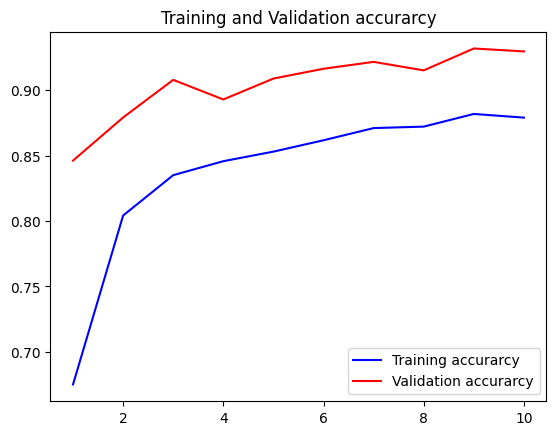

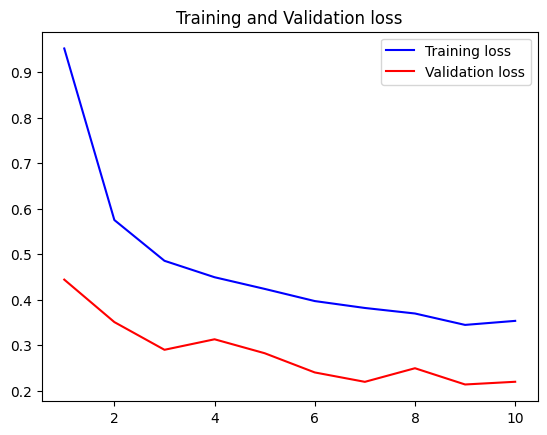

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load a sample image for testing
sample_image_path = '/content/download (1).jpeg'
img = image.load_img(sample_image_path, target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale the pixel values to [0, 1]

# Use the trained model for prediction
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions[0])

for subject_folder in os.listdir(data_root):
    if subject_folder.isdigit():  # Skip non-numeric folders
        subject_path = os.path.join(data_root, subject_folder)

        # Get the list of gesture folders for each subject
        gesture_folders = [gesture_folder for gesture_folder in os.listdir(subject_path) ]
# Map the index to the actual class label (assuming you have a list of class labels)
class_labels = gesture_folders
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted Class: {predicted_class_label}")


1/1 [==============================] - 0s 35ms/step
Predicted Class: 07_ok
